# Look at the pH of the system

In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
desktop_root_path = "/home/neil/"
pi_root_path = "/home/pi/"
if os.path.isdir(desktop_root_path):
    data_path = os.path.join(desktop_root_path,"growControl_Data")
    analysis_path = os.path.join(desktop_root_path,"growControl","Analysis")
elif os.path.isdir(pi_root_path):
    data_path = os.path.join(pi_path,"growControl_Data")
    analysis_path = os.path.join(pi_path,"growControl","Analysis")
else:
    raise FileNotFoundError("No valid path to the data was found!")

In [3]:
data_files = {}
for d in os.listdir(data_path):
    if not os.path.isfile(os.path.join(data_path,d)):
        continue
    root = d[:d.rfind("_")]
    full_path = os.path.join(data_path,d)
    if root not in data_files:
        data_files[root] = [full_path]
    else:
        data_files[root].append(full_path)

for key in data_files:
    print(key)
    for file in data_files[key]:
        print("\t{}".format(file))

Controller_ph_pump
	/home/neil/growControl_Data/Controller_ph_pump_1581982138.csv
	/home/neil/growControl_Data/Controller_ph_pump_1582035699.csv
	/home/neil/growControl_Data/Controller_ph_pump_1582084242.csv
	/home/neil/growControl_Data/Controller_ph_pump_1581653901.csv
	/home/neil/growControl_Data/Controller_ph_pump_1581984881.csv
	/home/neil/growControl_Data/Controller_ph_pump_1581654347.csv
	/home/neil/growControl_Data/Controller_ph_pump_1582090676.csv
	/home/neil/growControl_Data/Controller_ph_pump_1582084764.csv
	/home/neil/growControl_Data/Controller_ph_pump_1581986297.csv
sensor_ph_calibration_raw
	/home/neil/growControl_Data/sensor_ph_calibration_raw_2020-02-17T17:28:58.260498.json
	/home/neil/growControl_Data/sensor_ph_calibration_raw_2020-02-13T20:20:02.685957.json
ph
	/home/neil/growControl_Data/ph_1582035668.csv
	/home/neil/growControl_Data/ph_1581982011.csv
	/home/neil/growControl_Data/ph_1582084759.csv
	/home/neil/growControl_Data/ph_1581654252.csv
	/home/neil/growControl

In [4]:
def load_df(root_name):
    li = []
    for fname in data_files[root_name]:
        df_temp = pd.read_csv(fname,index_col=None,header=0)
        li.append(df_temp)
    df = pd.concat(li,axis=0,ignore_index=True)


    df["datetime"] = pd.to_datetime(df["datetime"])
    df.sort_values("datetime",inplace=True)
    df.reset_index(inplace=True,drop=True)
    return df
df_ph = load_df("ph")
df_control_ph = load_df("Controller_ph_pump")

In [5]:
df_ph["ph_avg_ewm_.1"] = df_ph["ph_raw"].ewm(adjust=False,alpha=.1).mean()
df_ph["ph_avg_ewm_.01"] = df_ph["ph_raw"].ewm(adjust=False,alpha=.01).mean()
df_ph["ph_avg_ewm_.001"] = df_ph["ph_raw"].ewm(adjust=False,alpha=.001).mean()

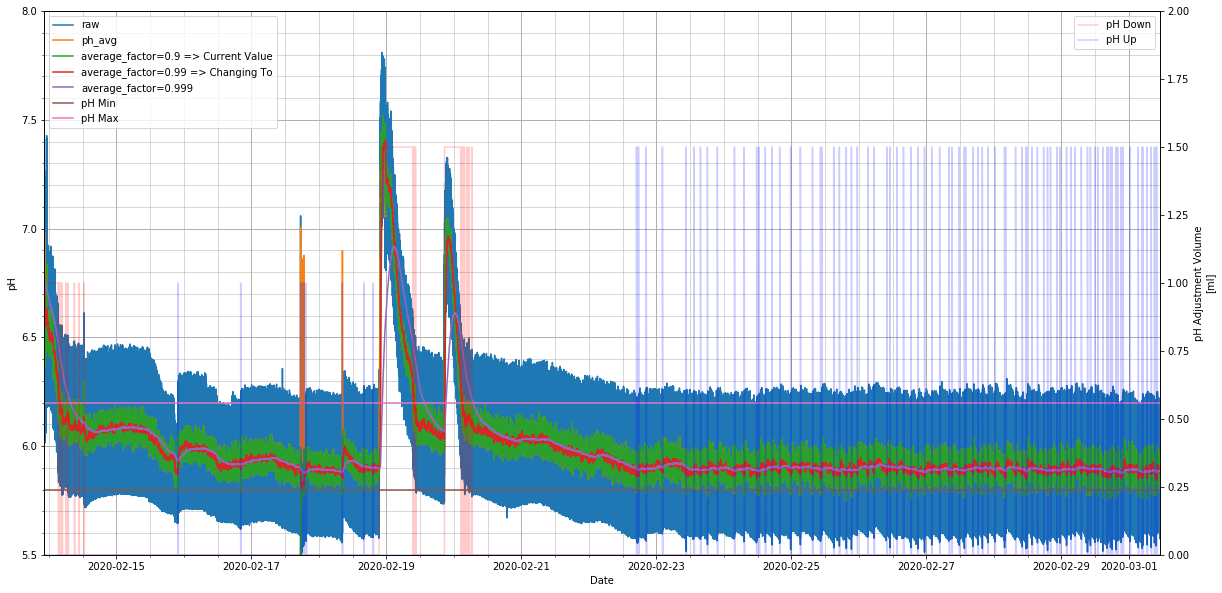

In [7]:
#plt.rcParams["figure.figsize"] = (50,25)
plt.rcParams["figure.figsize"] = (20,10)
fig, ax1 = plt.subplots()
ax1.set_xlabel("Date")
ax1.set_ylabel("pH")

ax1.plot(df_ph["datetime"],df_ph["ph_raw"],label="raw")
ax1.plot(df_ph["datetime"],df_ph["ph_avg"],label="ph_avg")

ax1.plot(df_ph["datetime"],df_ph["ph_avg_ewm_.1"],label="average_factor=0.9 => Current Value")
ax1.plot(df_ph["datetime"],df_ph["ph_avg_ewm_.01"],label="average_factor=0.99 => Changing To")
ax1.plot(df_ph["datetime"],df_ph["ph_avg_ewm_.001"],label="average_factor=0.999")

datetime_minmax = [df_ph["datetime"].min(),df_ph["datetime"].max()]
ax1.plot(datetime_minmax,[5.8,5.8],label="pH Min")
ax1.plot(datetime_minmax,[6.2,6.2],label="pH Max")

ax1.legend(loc="upper left")
ax1.minorticks_on()
ax1.grid(True,which="major",linewidth=1)
ax1.grid(True,which="minor",linewidth=.5)
plt.ylim((5.5,8.))
plt.xlim(datetime_minmax)

ax2 = ax1.twinx()
ax2.set_ylabel("pH Adjustment Volume\n[ml]")
ax2.plot(df_control_ph["datetime"],df_control_ph["ph_down_volume"],'r',alpha=.2,label="pH Down")
ax2.plot(df_control_ph["datetime"],df_control_ph["ph_up_volume"],'b',alpha=.2,label="pH Up")
ax2.legend(loc="upper right")
plt.ylim((0,2.0))
plt.xlim(datetime_minmax)
plt.savefig(os.path.join(analysis_path,"ph_data_{}.png".format(datetime.datetime.now().strftime("%Y%m%dT%H%M%S"))))
plt.show()